# Ticket Queueing 

#### Victoria Madison and Teresa Simunich

CBE 40455 Process Operations Final Project  
December 11, 2017

## Introduction

A tradition exists at Notre Dame during the final home game of the Notre Dame Football Season. Student seniors bring marshmallows into the stadium with them upon entrance, and a marshmallow fight commences during halftime. Completely aware of the tradition, the stadium staff attempt to reduce the amount of marshmallows that are smuggled into the stadium by implementing an additional step in the queue to enter the stadium through the student gates. During this step, the ushers inspect students for hidden bagged marshmallows before allowing them to proceed in the queue to enter the stadium. The time added by this additional step in the queue noticably lengthens the total queue time. As the last home game of the season, student attendance is also higher than average, resulting in additional students in the queue.

For a standard home game, the entrance line has only two steps: 
- One in which your bag (if applicable) is checked for food, drinks, or other;
- One in which your student ticket and ID are verified and scanned, permitting entrance to the game.

For the last home game of the season, the additional step is added between the two preexisting steps.
- Check students for contraband marshmallows.

With the following segments of python, this code aims to determine the number of additional staff members needed to perform operations in the queue to relieve the excessive total queue time for the final home football game.

In [1]:
# Import libraries

!pip install simpy

import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

  Using cached simpy-3.0.10-py2.py3-none-any.whl


## Model for a Standard Football Game

The following assumptions are made to implement the model:
- Approximately 70% of undergraduate students from the Univeristy of Notre Dame, Saint Mary's College, and Holy Cross College attend the game.
- Approximately 10% of higher education students from the Graduate Program and ND Law Program attend the game.
- Approximate enrollments for each student category.
- Time to check a bag is 0-5 seconds, where 0 is a possibility to represent students without bags.
- Time to verify a ticket is 1-10 seconds.
- There exist 2 ushers to check bags and 2 ushers to verify tickets in each of the four student entrance lines.

In [2]:
# Model for a standard football game

# Perentage Attendance
ugrad = 0.7
grad = 0.1

# Enrollment
ND_ugrad = 8000
HC_ugrad = 500
SMC_ugrad = 1600
Law = 500
ND_grad = 2200

# Anticipated Attendance
u_grad = ugrad*(ND_ugrad + HC_ugrad + SMC_ugrad)
Grad = grad*(Law + ND_grad)
N_Students = Grad + u_grad

# Creates Environment
env1 = simpy.Environment()

# Creates queue lines
student_queue = simpy.Store(env1)
ticket_queue = simpy.Store(env1)

# Simulates students entering the queue to the stadium
def student_generator(env1, student_queue):
    StudentID = 0
    UsherID = 1
    while StudentID <= N_Students:
        StudentID += 1
        # Arrivals occur randomly every 0-1 seconds
        yield env1.timeout(random.random())
        yield student_queue.put(StudentID)
        writeLog(StudentID, "Entering Queue", UsherID, env1.now)
        
def bag_check(env1, name, student_queue):
    bags_checked = 0
    while True:
        StudentID = yield student_queue.get()
        writeLog(StudentID, "Arrive at Bag Check", name, env1.now)
        yield env1.timeout(random.randint(0, 5)) #seconds
        yield ticket_queue.put(StudentID)
        writeLog(StudentID, "Bag Check Finish", name, env1.now)
        bags_checked += 1 
        
def ticket_verification(env1, name, student_queue):
    tickets_verified = 0
    while True:
        StudentID = yield ticket_queue.get()
        writeLog(StudentID, "Arrive at Ticket Check", name, env1.now)
        yield env1.timeout(random.randint(1,10))
        writeLog(StudentID, "Entered Game", name, env1.now)
        tickets_verified += 1
        
log=[]
def writeLog(StudentID, stage, UsherID, event):
    log.append([StudentID, stage, UsherID, env1.now])
               
env1.process(student_generator(env1, student_queue))

env1.process(bag_check(env1, "Freshman A", student_queue))
env1.process(bag_check(env1, "Freshman B", student_queue))
env1.process(bag_check(env1, "Sophomore A", student_queue))
env1.process(bag_check(env1, "Sophomore B", student_queue))
env1.process(bag_check(env1, "Junior A", student_queue))
env1.process(bag_check(env1, "Junior B", student_queue))
env1.process(bag_check(env1, "Senior A", student_queue))
env1.process(bag_check(env1, "Senior B", student_queue))

env1.process(ticket_verification(env1, "Freshman 1", student_queue))
env1.process(ticket_verification(env1, "Freshman 2", student_queue))
env1.process(ticket_verification(env1, "Sophomore 1", student_queue))
env1.process(ticket_verification(env1, "Sophomore 2", student_queue))
env1.process(ticket_verification(env1, "Junior 1", student_queue))
env1.process(ticket_verification(env1, "Junior 2", student_queue))
env1.process(ticket_verification(env1, "Senior 1", student_queue))
env1.process(ticket_verification(env1, "Senior 2", student_queue))

# The simulation processes the expected student attendance.
env1.run() 

In [3]:
# The collected data is organized from the log using Pandas
df1 = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in log])
df1 = df1.pivot(index =0, columns =1, values =3).reset_index()
df1 = df1.set_index([0]).dropna()
df1.index.rename('StudentID',inplace=True)

Mean Queue Time =  11.80 min.

Mean Times per Step:

     Bag Check Queue =   0.03 sec.
     Bag Check Process Time =   2.50 sec.
     Ticket Check Queue =  11.67 min.
     Ticket Check Process Time =   5.48 sec.


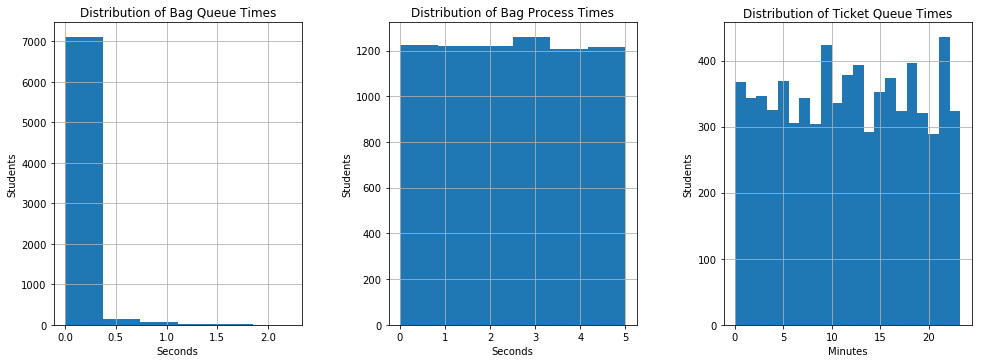

In [4]:
# The time for each step of the process is calculated and displayed verbally and graphically.

total_queue1 = (df1['Entered Game']-df1['Entering Queue'])/60
bag_queue1 = df1['Arrive at Bag Check']-df1['Entering Queue']
bag_process1 = df1['Bag Check Finish']-df1['Arrive at Bag Check']
ticket_queue1 = (df1['Arrive at Ticket Check']-df1['Bag Check Finish'])/60
ticket_process1 = df1['Entered Game']-df1['Arrive at Ticket Check']

print('Mean Queue Time = {0:6.2f} min.\n'.format((total_queue1).mean()))

print('Mean Times per Step:\n')
print('     Bag Check Queue = {0:6.2f} sec.'.format(bag_queue1.mean()))
print('     Bag Check Process Time = {0:6.2f} sec.'.format(bag_process1.mean()))
print('     Ticket Check Queue = {0:6.2f} min.'.format(ticket_queue1.mean()))
print('     Ticket Check Process Time = {0:6.2f} sec.'.format(ticket_process1.mean()))

    
plt.figure(figsize=(15, 5))
plt.subplot(131)
bag_queue1.hist(bins=6)
plt.title('Distribution of Bag Queue Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(132)
bag_process1.hist(bins=6)
plt.title('Distribution of Bag Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(133)
ticket_queue1.hist(bins=21)
plt.title('Distribution of Ticket Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

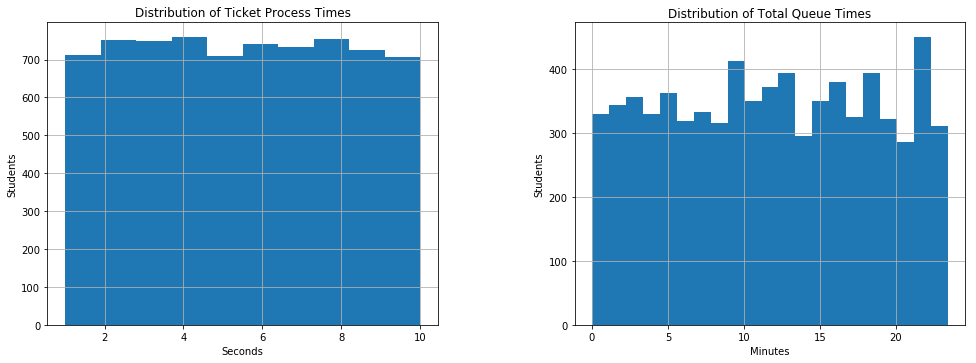

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
ticket_process1.hist(bins=10)
plt.title('Distribution of Ticket Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(122)
total_queue1.hist(bins=21)
plt.title('Distribution of Total Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

## Model for the Last Home Football Game

The following assumptions are made to implement the model:
- Approximately 90% of undergraduate students from the Univeristy of Notre Dame, Saint Mary's College, and Holy Cross College attend the game.
- Approximately 10% of higher education students from the Graduate Program and ND Law Program attend the game.
- Approximate enrollments for each student category.
- Time to check a bag is 0-5 seconds, where 0 is a possibility to represent students without bags.
- Time to inspect for marshmallows is 3-15 seconds.
- Time to verify a ticket is 1-10 seconds.
- There exist 2 ushers to check bags, 2 ushers to inspect for marshmallows, and 2 ushers to verify tickets in each of the four student entrance lines.

In [6]:
# Model for the Last Notre Dame Home Football Game

# Perentage Attendance
ugrad = 0.9
grad = 0.1

# Enrollment
ND_ugrad = 8000
HC_ugrad = 500
SMC_ugrad = 1600
Law = 500
ND_grad = 2200

# Anticipated Attendance
u_grad = ugrad*(ND_ugrad + HC_ugrad + SMC_ugrad)
Grad = grad*(Law + ND_grad)
N_Students = Grad + u_grad

# Creates Environment
env2 = simpy.Environment()

# Creates queue lines
student_queue = simpy.Store(env2)
ticket_queue = simpy.Store(env2)
mallow_queue = simpy.Store(env2)


def student_generator(env2, student_queue):
    StudentID = 0
    UsherID = 1
    while StudentID <= N_Students:
        StudentID += 1
        yield env2.timeout(random.random())
        yield student_queue.put(StudentID)
        writeLog(StudentID, "Entering Queue", "-", env2.now)
        
def bag_check(env2, name, student_queue):
    bags_checked = 0
    while True:
        StudentID = yield student_queue.get()
        writeLog(StudentID, "Arrive at Bag Check", name, env2.now)
        yield env2.timeout(random.randint(0, 5))
        yield mallow_queue.put(StudentID)
        writeLog(StudentID, "Bag Check Finish", name, env2.now)
        bags_checked += 1  
        
def mallow_check(env2, name, student_queue):
    mallows_checked = 0
    while True:
        StudentID = yield mallow_queue.get()
        writeLog(StudentID, "Arrive at Mallow Check", name, env2.now)
        yield env2.timeout(random.randint(3,15))
        yield ticket_queue.put(StudentID)
        writeLog(StudentID, "Mallow Check Finish", name, env2.now)
        mallows_checked += 1   
        
def ticket_verification(env2, name, student_queue):
    tickets_verified = 0
    while True:
        StudentID = yield ticket_queue.get()
        writeLog(StudentID, "Arrive at Ticket Check", name, env2.now)
        yield env2.timeout(random.randint(1,10))
        writeLog(StudentID, "Entered Game", name, env2.now)
        tickets_verified += 1
        
log=[]
def writeLog(StudentID, stage, UsherID, event):
    log.append([StudentID, stage, UsherID, env2.now])
               
env2.process(student_generator(env2, student_queue))

env2.process(bag_check(env2, "Freshman A", student_queue))
env2.process(bag_check(env2, "Freshman B", student_queue))
env2.process(bag_check(env2, "Sophomore A", student_queue))
env2.process(bag_check(env2, "Sophomore B", student_queue))
env2.process(bag_check(env2, "Junior A", student_queue))
env2.process(bag_check(env2, "Junior B", student_queue))
env2.process(bag_check(env2, "Senior A", student_queue))
env2.process(bag_check(env2, "Senior B", student_queue))

env2.process(mallow_check(env2, "Freshman Y", student_queue))
env2.process(mallow_check(env2, "Freshman Z", student_queue))
env2.process(mallow_check(env2, "Sophomore Y", student_queue))
env2.process(mallow_check(env2, "Sophomore Z", student_queue))
env2.process(mallow_check(env2, "Junior Y", student_queue))
env2.process(mallow_check(env2, "Junior Z", student_queue))
env2.process(mallow_check(env2, "Senior Y", student_queue))
env2.process(mallow_check(env2, "Senior Z", student_queue))

env2.process(ticket_verification(env2, "Freshman 1", student_queue))
env2.process(ticket_verification(env2, "Freshman 2", student_queue))
env2.process(ticket_verification(env2, "Sophomore 1", student_queue))
env2.process(ticket_verification(env2, "Sophomore 2", student_queue))
env2.process(ticket_verification(env2, "Junior 1", student_queue))
env2.process(ticket_verification(env2, "Junior 2", student_queue))
env2.process(ticket_verification(env2, "Senior 1", student_queue))
env2.process(ticket_verification(env2, "Senior 2", student_queue))


env2.run() 

In [7]:
# The collected data is organized from the log using Pandas
df2 = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in log])
df2 = df2.pivot(index =0, columns =1, values =3).reset_index()
df2 = df2.set_index([0]).dropna()
df2.index.rename('StudentID',inplace=True)

In [8]:
# The time for each step of the process is calculated and displayed verbally and graphically.

total_queue2 = (df2['Entered Game']-df2['Entering Queue'])/60
bag_queue2 = df2['Arrive at Bag Check']-df2['Entering Queue']
bag_process2 = df2['Bag Check Finish']-df2['Arrive at Bag Check']
mallow_queue2 = (df2['Arrive at Mallow Check'] - df2['Bag Check Finish'])/60
mallow_process2 = df2['Mallow Check Finish']-df2['Arrive at Mallow Check']
ticket_queue2 = df2['Arrive at Ticket Check']-df2['Mallow Check Finish']
ticket_process2 = df2['Entered Game']-df2['Arrive at Ticket Check']


print('Mean Queue Time = {0:6.2f} min.\n'.format((total_queue2).mean()))

print('Mean Time in Process:\n')
print('     Bag Check Queue = {0:6.2f} sec.'.format(bag_queue2.mean()))
print('     Bag Check Process Time = {0:6.2f} sec.'.format(bag_process2.mean()))
print('     Mallow Check Queue = {0:6.2f} min.'.format(mallow_queue2.mean()))
print('     Mallow Check Process Time = {0:6.2f} sec.'.format(mallow_process2.mean()))
print('     Ticket Check Queue = {0:6.2f} sec.'.format(ticket_queue2.mean()))
print('     Ticket Check Process Time = {0:6.2f} sec.'.format(ticket_process2.mean()))


Mean Queue Time =  48.80 min.

Mean Time in Process:

     Bag Check Queue =   0.03 sec.
     Bag Check Process Time =   2.48 sec.
     Mallow Check Queue =  48.52 min.
     Mallow Check Process Time =   8.99 sec.
     Ticket Check Queue =   0.03 sec.
     Ticket Check Process Time =   5.53 sec.


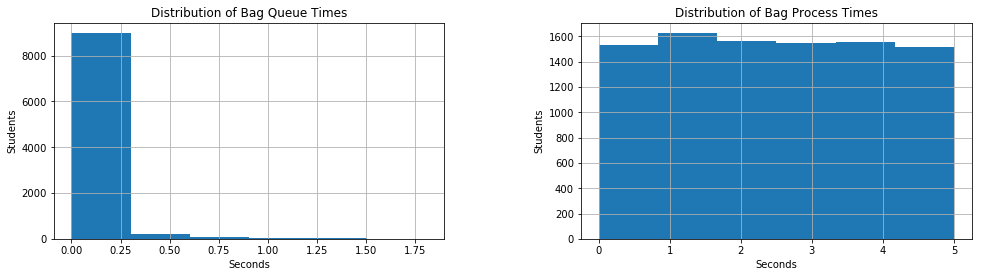

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
bag_queue2.hist(bins=6)
plt.title('Distribution of Bag Queue Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(122)
bag_process2.hist(bins=6)
plt.title('Distribution of Bag Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplots_adjust(top=0.8, bottom=0.2, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

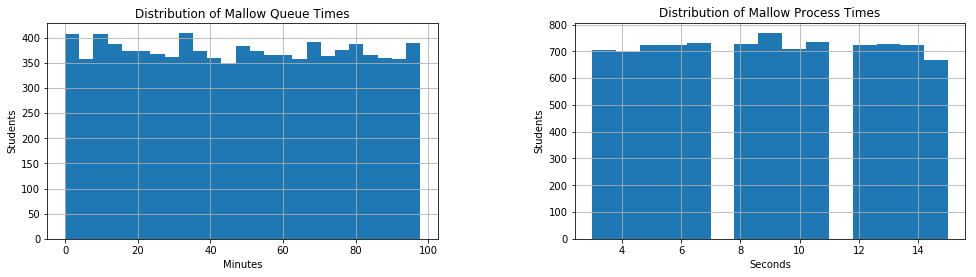

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
mallow_queue2.hist(bins=25)
plt.title('Distribution of Mallow Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplot(122)
mallow_process2.hist(bins=15)
plt.title('Distribution of Mallow Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplots_adjust(top=0.8, bottom=0.2, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

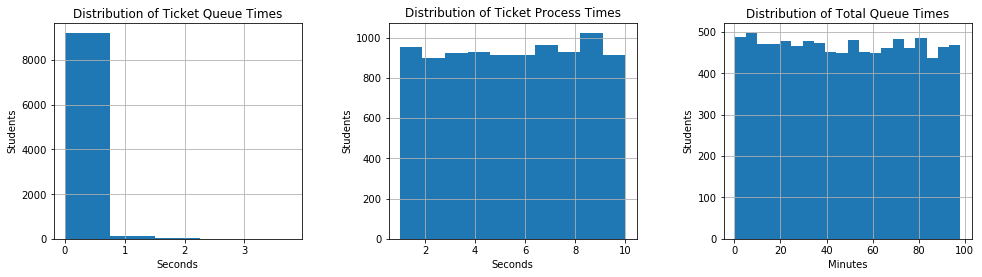

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
ticket_queue2.hist(bins=5)
plt.title('Distribution of Ticket Queue Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(132)
ticket_process2.hist(bins=10)
plt.title('Distribution of Ticket Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(133)
total_queue2.hist(bins=20)
plt.title('Distribution of Total Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplots_adjust(top=0.8, bottom=0.2, left=0.10, right=0.95, hspace=0.25,wspace=0.35)

## 2nd Model for the Last Home Football Game -Additional Staff

The average queue time for a standard game is approximately 11 minutes.
The marshmallow check lengthens the average queue time for the last home game to approximately 49 minutes.
To decrease this queue time, additional ushers are added.

The following assumptions are made to implement the model:
- Approximately 90% of undergraduate students from the Univeristy of Notre Dame, Saint Mary's College, and Holy Cross College attend the game.
- Approximately 10% of higher education students from the Graduate Program and ND Law Program attend the game.
- Approximate enrollments for each student category.
- Time to check a bag is 0-5 seconds, where 0 is a possibility to represent students without bags.
- Time to inspect for marshmallows is 3-15 seconds.
- Time to verify a ticket is 1-10 seconds.
- There exist 2 ushers to check bags, 2 ushers to inspect for marshmallows, and 2 ushers to verify tickets in each of the four student entrance lines.
- Additional ushers can be added to serve any operation.

In [12]:
# Model for the Last Notre Dame Home Football Game - Additional Staff

# Perentage Attendance
ugrad = 0.9
grad = 0.1

# Enrollment
ND_ugrad = 8000
HC_ugrad = 500
SMC_ugrad = 1600
Law = 500
ND_grad = 2200

# Anticipated Attendance
u_grad = ugrad*(ND_ugrad + HC_ugrad + SMC_ugrad)
Grad = grad*(Law + ND_grad)
N_Students = Grad + u_grad

# Creates Environment
env3 = simpy.Environment()

student_queue = simpy.Store(env3)
ticket_queue = simpy.Store(env3)
mallow_queue = simpy.Store(env3)


def student_generator(env3, student_queue):
    StudentID = 0
    UsherID = 1
    while StudentID <= N_Students:
        StudentID += 1
        yield env3.timeout(random.random())
        yield student_queue.put(StudentID)
        writeLog(StudentID, "Entering Queue", "-", env3.now)
        
def bag_check(env3, name, student_queue):
    bags_checked = 0
    while True:
        StudentID = yield student_queue.get()
        writeLog(StudentID, "Arrive at Bag Check", name, env3.now)
        yield env3.timeout(random.randint(0, 5))
        yield mallow_queue.put(StudentID)
        writeLog(StudentID, "Bag Check Finish", name, env3.now)
        bags_checked += 1  
        
def mallow_check(env3, name, student_queue):
    mallows_checked = 0
    while True:
        StudentID = yield mallow_queue.get()
        writeLog(StudentID, "Arrive at Mallow Check", name, env3.now)
        yield env3.timeout(random.randint(3,15))
        yield ticket_queue.put(StudentID)
        writeLog(StudentID, "Mallow Check Finish", name, env3.now)
        mallows_checked += 1  
        
def ticket_verification(env3, name, student_queue):
    tickets_verified = 0
    while True:
        StudentID = yield ticket_queue.get()
        writeLog(StudentID, "Arrive at Ticket Check", name, env3.now)
        yield env3.timeout(random.randint(1,10))
        writeLog(StudentID, "Entered Game", name, env3.now)
        tickets_verified += 1
        
log=[]
def writeLog(StudentID, stage, UsherID, event):
    log.append([StudentID, stage, UsherID, env3.now])
               
env3.process(student_generator(env3, student_queue))

env3.process(bag_check(env3, "Freshman A", student_queue))
env3.process(bag_check(env3, "Freshman B", student_queue))
env3.process(bag_check(env3, "Sophomore A", student_queue))
env3.process(bag_check(env3, "Sophomore B", student_queue))
env3.process(bag_check(env3, "Junior A", student_queue))
env3.process(bag_check(env3, "Junior B", student_queue))
env3.process(bag_check(env3, "Senior A", student_queue))
env3.process(bag_check(env3, "Senior B", student_queue))

env3.process(ticket_verification(env3, "Freshman 1", student_queue))
env3.process(ticket_verification(env3, "Freshman 2", student_queue))
env3.process(ticket_verification(env3, "Sophomore 1", student_queue))
env3.process(ticket_verification(env3, "Sophomore 2", student_queue))
env3.process(ticket_verification(env3, "Junior 1", student_queue))
env3.process(ticket_verification(env3, "Junior 2", student_queue))
env3.process(ticket_verification(env3, "Senior 1", student_queue))
env3.process(ticket_verification(env3, "Senior 2", student_queue))

env3.process(mallow_check(env3, "Freshman Y", student_queue))
env3.process(mallow_check(env3, "Freshman Z", student_queue))
env3.process(mallow_check(env3, "Sophomore Y", student_queue))
env3.process(mallow_check(env3, "Sophomore Z", student_queue))
env3.process(mallow_check(env3, "Junior Y", student_queue))
env3.process(mallow_check(env3, "Junior Z", student_queue))
env3.process(mallow_check(env3, "Senior Y", student_queue))
env3.process(mallow_check(env3, "Senior Z", student_queue))

#Additional Staff

env3.process(mallow_check(env3, "Freshman X", student_queue))
env3.process(mallow_check(env3, "Sophomore X", student_queue))
env3.process(mallow_check(env3, "Junior X", student_queue))
env3.process(mallow_check(env3, "Senior X", student_queue))

env3.process(mallow_check(env3, "Freshman W", student_queue))
env3.process(mallow_check(env3, "Sophomore W", student_queue))
env3.process(mallow_check(env3, "Junior W", student_queue))
env3.process(mallow_check(env3, "Senior W", student_queue))

env3.run() 

In [13]:
df3 = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in log])
df3 = df3.pivot(index =0, columns =1, values =3).reset_index()
df3 = df3.set_index([0]).dropna()
df3.index.rename('StudentID',inplace=True)

In [14]:
total_queue3 = (df3['Entered Game']-df3['Entering Queue'])/60
bag_queue3 = df3['Arrive at Bag Check']-df3['Entering Queue']
bag_process3 = df3['Bag Check Finish']-df3['Arrive at Bag Check']
mallow_queue3 = (df3['Arrive at Mallow Check'] - df3['Bag Check Finish'])/60
mallow_process3 = df3['Mallow Check Finish']-df3['Arrive at Mallow Check']
ticket_queue3 = (df3['Arrive at Ticket Check']-df3['Mallow Check Finish'])/60
ticket_process3 = df3['Entered Game']-df3['Arrive at Ticket Check']


print('Mean Queue Time = {0:6.2f} min.\n'.format((total_queue3).mean()))

print('Mean Time in Process:\n')
print('     Bag Check Queue = {0:6.2f} sec.'.format(bag_queue3.mean()))
print('     Bag Check Process Time = {0:6.2f} sec.'.format(bag_process3.mean()))
print('     Mallow Check Queue = {0:6.2f} min.'.format(mallow_queue3.mean()))
print('     Mallow Check Process Time = {0:6.2f} sec.'.format(mallow_process3.mean()))
print('     Ticket Check Queue = {0:6.2f} min.'.format(ticket_queue3.mean()))
print('     Ticket Check Process Time = {0:6.2f} sec.'.format(ticket_process3.mean()))

Mean Queue Time =  14.70 min.

Mean Time in Process:

     Bag Check Queue =   0.03 sec.
     Bag Check Process Time =   2.50 sec.
     Mallow Check Queue =   4.50 min.
     Mallow Check Process Time =   8.98 sec.
     Ticket Check Queue =   9.92 min.
     Ticket Check Process Time =   5.49 sec.


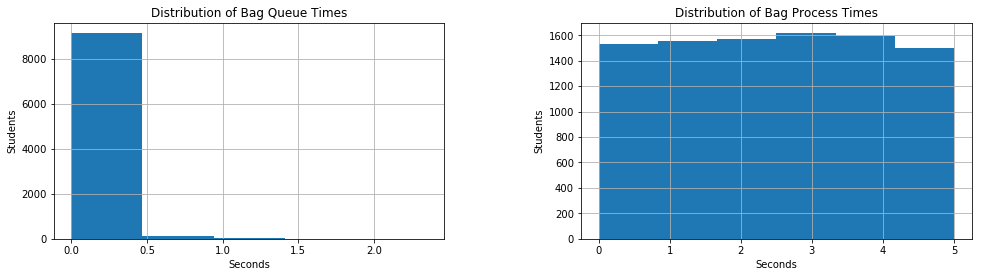

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
bag_queue3.hist(bins=5)
plt.title('Distribution of Bag Queue Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(122)
bag_process3.hist(bins=6)
plt.title('Distribution of Bag Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplots_adjust(top=0.8, bottom=0.2, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

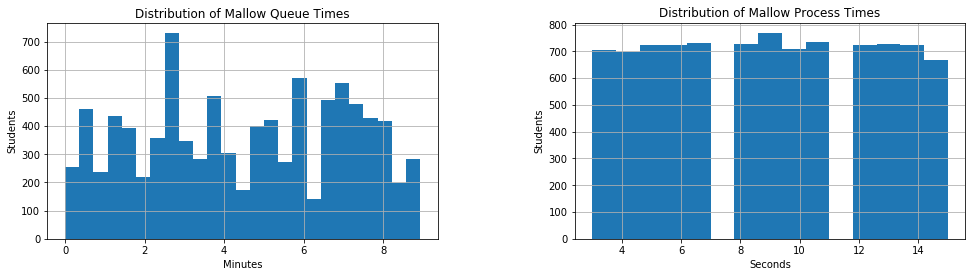

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
mallow_queue3.hist(bins=25)
plt.title('Distribution of Mallow Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplot(122)
mallow_process2.hist(bins=15)
plt.title('Distribution of Mallow Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplots_adjust(top=0.8, bottom=0.2, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

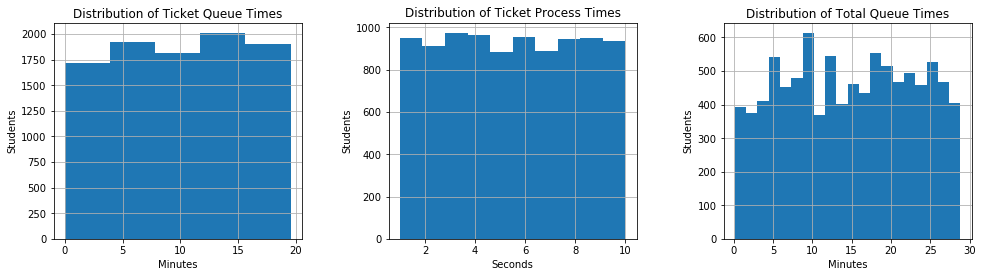

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
ticket_queue3.hist(bins=5)
plt.title('Distribution of Ticket Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplot(132)
ticket_process3.hist(bins=10)
plt.title('Distribution of Ticket Process Times')
plt.ylabel('Students')
plt.xlabel('Seconds')

plt.subplot(133)
total_queue3.hist(bins=20)
plt.title('Distribution of Total Queue Times')
plt.ylabel('Students')
plt.xlabel('Minutes')

plt.subplots_adjust(top=0.8, bottom=0.2, left=0.10, right=0.95, hspace=0.25,wspace=0.35)

## Conclusion

With the addition of 2 ushers per student line (8 ushers total) to check guests for marshmallows, the average queue time decreases from about 49 minutes to 14.5 minutes. This is a comparable time to the average queue line for a standard home football game at 11 minutes.
